## Preliminaries 

This tutorial illustrates the typical workflow one use to obtain results in the paper for the validation datasets. As such, it uses high level scripts and does **NOT** aim to illustrate how to write your own code.

In [16]:
import matplotlib.pyplot as plt

### Notation 

* Energy: The energy of a given expression $f_i$is $H=-\log p(f_i|D)$. 

## Step 1: Determine the number of variables

The first step is to determine the number of variables necessary for the sampling. To do this, we start by running the MCMC with a "large" number of variables. For this we use the "sample_charac_parallel.py" script, whose syntax is as follows:

In [3]:
!python sample_charac_parallel.py -h

Usage: sample_charac_parallel.py [options] DATASET

Options:
  -h, --help            show this help message and exit
  -p PPARFILE, --priorpar=PPARFILE
                        Use priors from this file (default: no priors)
  -n NSAMPLE, --nsample=NSAMPLE
                        Number of samples (default: 100000)
  -t THIN, --thin=THIN  Thinning of the sample (default: 10)
  -b BURNIN, --burnin=BURNIN
                        Burn-in (default: 1000)
  -T NT, --nT=NT        Number of temperatures (default: 10)
  -s TF, --Tf=TF        Factor between temperatures (default: 1.20)
  -a ANNEAL, --anneal=ANNEAL
                        Annealing threshold. If there are no tree swaps for
                        more than this number of steps, the parallel tempering
                        is annealed (default: 100)
  -f ANNEALF, --annealf=ANNEALF
                        Annealing factor: all temperatures are multiplied by
                        this factor during the heating phase of the anneal

For the purpose of this tutorial, we will use some quick-and-dirty parameters. For real purposes, the default parameters are a good starting point (although -n 100000 is often too much; -n 10000 is generally more reasonable). Optionally, you may want to play with the following:
* The burn-in parameter controls how many samples of the MCMC are disregarded before the actual sampling starts. The longest the burn-in, the better, so often values of 5,000 or even 10,000 are more appropriate. If, after running the sampling, you observe that the "energy" decreased during the sampling process 

In [5]:
!python sample_charac_parallel.py -p ../Prior/final_prior_param_sq.named_equations.nv5.np10.2016-07-11\ 17\:12\:38.129639.dat -n 1000 Citations 2>/dev/null

This creates a file DATASET/sample_charac_parallel__PPARFILE.dat which contains:
* Sampling parameters (lines 1-4). 
* The trace of the MCMC sampling, that is, the expressions sampled. Each row corresponds to one expression and the columns (separated by "||" are: sample_number, energy, energy, BIC, BIC, expression_size, cannonical_expression, full_expression, parameter_values, number_of_iterations_without_parallel_tempering_changes.
* The histogram of the expression size (after line "# formula size").
* Use frequency for each feature (after line "# variable use"). A value of 1 corresponds to a feature that has been used in absolutely all expressions sampled; a value of 0 corresponds to a feature that has never been used in any of the expressions sampled.
* Histogram of the number of parameters used (after line "# parameters").

Now let's look at this file in some more detail, and discuss the most important aspects. First, let's take a look at the energy during the sampling process.

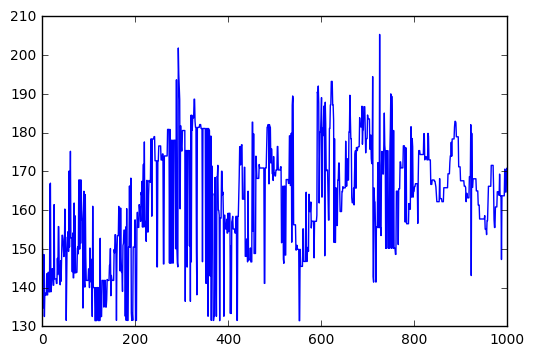

In [10]:
with open('Citations/sample_charac_parallel__final_prior_param_sq.named_equations.nv5.np10.2016-07-11 17:12:38.129639.dat', 'r') as inf:
    lines = inf.readlines()
energies = [l.split(' || ')[2] for l in lines if '||' in l]
plt.plot(energies)
plt.show()

If this plot looks reasonably flat (aside from fluctuations), then we can go ahead. Otherwise, we would need to increase the burn-in time (or check for other reasons for the non-stationarity of the energy).

Next, let's take a look at another important quantity that could be indicative of improprer equilibration of the sample, namely, the number of iterations without swaps between parallel tempering samples.

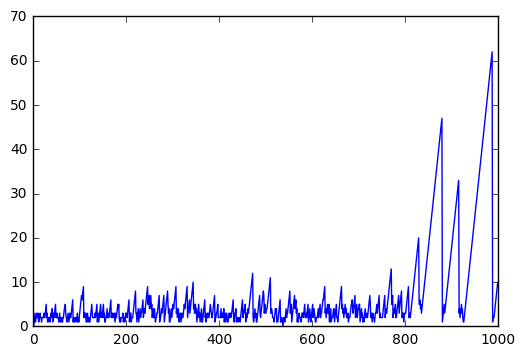

In [11]:
noswiter = [l.split(' || ')[-1] for l in lines if '||' in l]
plt.plot(noswiter)
plt.show()

This is the number of iterations since the last swap of configurations between parallel tempering samples occurred. If this value goes often to the parameter ANNEAL (specified by the -a option, with default 100) and then drops, this is an indication that each parallel tempering sample is running independently of the others (no swaps between temperatures are taking place). In that case, we should probably increase the number of temperatures in the parallel tempering (with -T) and decrease the factor separating temperatures (with -s). The default is -T 10 -s 1.20, but for large datasets we have used -T 20 -s 1.08 (of course, T must be T>1).

If the two plots above look OK, then we can finally look at how many variables are typically used in the sampling process.

In [14]:
print ''.join(lines[lines.index('# parameters\n')+1:])

0 0.007
1 0.144
2 0.187
3 0.167
4 0.298
5 0.178
6 0.018
7 0.001
8 0.0
9 0.0
10 0.0



So it seems that the models sampled never use large numbers of parameters. For example, if 18% of the expressions sampled use 5 parameters and only 1.8% use 6 parameters, we should probably use only 5 parameters (we typically set the threshold at 5%). We could run samples with a maximum of 5 and 6 parameters and verify that this number is appropriate. For the purposes of this tutorial, we assume that 5 is indeed a reasonable number of parameters.

We could do something similar with the features: if a feature is never used (or very rarely) we should probably go ahead and remove it from our analysis. In this case, we will use all the features.

## Step 2: Sample expressions 

Now that we have the right number of parameters, we go ahead and run a good MCMC to analyze what kind of models we get. As before, here we will run a quick-and-dirty MCMC, but this is the place where you would want to have your computer sampling for a while.

In [18]:
# CAREFUL: Running this may take a long while!
!python sample_charac_parallel.py -p ../Prior/final_prior_param_sq.named_equations.nv5.np5.2016-07-11\ 17\:12\:37.336441.dat Citations 1>/dev/null 2>/dev/null

^C


## Step 3: Explore sampled partitions

Next, we can take a look at the 10 most plausible models that were sampled during the MCMC and print some information about each of these models, including their BIC, leave-one-out (LOO) validation error, etc. For this, we use the "get_top_models.py" script, which takes as input the sample_charac_parallel file that comes out of "sample_charac_parallel.py". For large datasets, obtaining LOO validation errors is not feasible; in those cases one should use the -l flag.

In [1]:
!python get_top_models.py Citations/sample_charac_parallel__final_prior_param_sq.named_equations.nv5.np6.2016-07-11\ 17\:12\:38.479866.dat

>>>>> MODEL 1 131.086911910139 253.100943352959 c1*c1984
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
--------------------------------------------------------------------------------
Dataset:  Citations
Model:    (c1984 * _a3_)
LaTeX:    c_{1} c_{1984}
Param:    {'_a2_': 1.0, '_a3_': 6.189934185067456, '_a1_': 1.0, '_a0_': 1.0, '_a5_': 1.0, '_a4_': 1.0}
SSE:      96447.0914441
RMSE:     66.2114695653
BIC:      253.100943352959
Prior_c:  {'Nopi2_cos': 0.0, 'Nopi_tan': 8.11972375729, 'Nopi2_tanh': 0.644459562348, 'Nopi2_pow3': 0.0, 'Nopi2_pow2': 0.0, 'Nopi2_log': 0.0, 'Nopi_log': 5.11442917436, 'Nopi_sqrt': 5.10

At the end of this long list, there is a LaTeX table with the models, their plausibilities, and their LOO validation error. Since this toy dataset is small, the formulas proposed are relatively simple; with more data, models would presumably get more sophisticated.

Individual models can be explored using the "model_charac.py" script. For example, to compare the models above to a model that is simply a constant we could run:

In [21]:
!python model_charac.py -p ../Prior/final_prior_param_sq.named_equations.nv5.np5.2016-07-11\ 17\:12\:37.336441.dat Citations "_a0_"

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
--------------------------------------------------------------------------------
Dataset:  Citations
Model:    _a0_
LaTeX:    c_{1}
Param:    {'_a0_': 105.86363744510504}
SSE:      344732.590909
RMSE:     125.178525407
BIC:      281.123980920246
Prior_c:  {'Nopi2_cos': 0.0, 'Nopi_tan': 8.01154085322, 'Nopi2_tanh': 0.143156250862, 'Nopi2_pow3': 0.0, 'Nopi2_pow2': 0.0, 'Nopi2_log': 0.00188427121582, 'Nopi_log': 5.08775603879, 'Nopi_sqrt': 5.08925434026, 'Nopi_abs': 6.7037453243, 'Nopi_+': 5.5899643897, 'Nopi_*': 4.37559352005, 'Nopi2_sin': 0.000596381816954, 'Nopi_**'

In this case we observe that this model is considerably worse than the most plausible ones.

We can also analize in more detail the properties of one model. Let's do this writing real code, rather than running scripts. In particular let's fit the parameters of one particular model and see what the fit looks like:

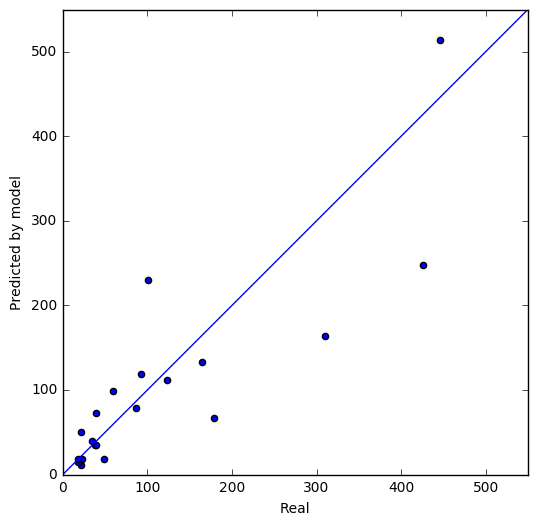

MAE = 40.1309493864


In [42]:
import sys
sys.path.append('..')
from numpy import mean
from mcmc import Tree
from iodata import read_data

# Read the data
data, x, y = read_data('Citations')

# Create a formula with the model c1984**a0
f = Tree(x=x, y=y, from_string='(c1984 ** _a0_)')

# Fit the value of the parameter and plot the fit
f.get_sse(fit=True)
ypred = f.predict(x)
plt.figure(figsize=(6, 6))
plt.scatter(y, ypred)
plt.plot([0, 550], [0, 550])
plt.xlabel('Real')
plt.ylabel('Predicted by model')
plt.xlim(0, 550)
plt.ylim(0, 550)
plt.show()
print 'MAE =', mean(abs(y - ypred))

Of course, this is simply the error of the fit. We could be a bit more rigorous and calculate a validation error, e.g. using a leave-one-out validation:

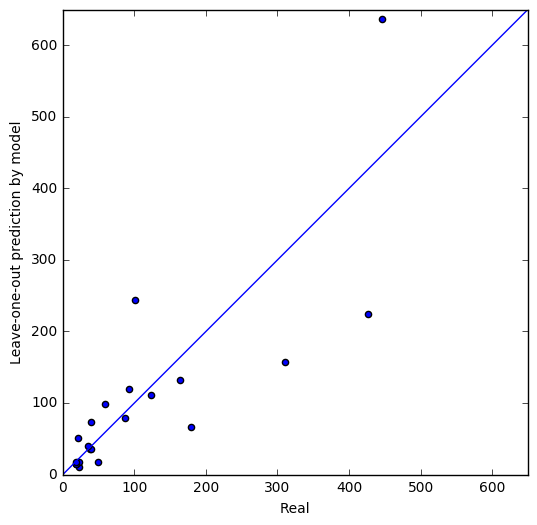

MAE = 47.8612648427


In [61]:
from sklearn.model_selection import LeaveOneOut

# Leave-one-out cross-validation
ypred = []
loo = LeaveOneOut()
for tr, te in loo.split(range(len(x))):
    xtr, ytr = x.iloc[tr], y.iloc[tr]
    xte, yte = x.iloc[te], y.iloc[te]
    f = Tree(x=xtr, y=ytr, from_string='(c1984 ** _a0_)')
    f.get_sse(fit=True)
    ypred += list(f.predict(xte))

# Show the predictions
plt.figure(figsize=(6, 6))
plt.scatter(y, ypred)
plt.plot([0, 650], [0, 650])
plt.xlabel('Real')
plt.ylabel('Leave-one-out prediction by model')
plt.xlim(0, 650)
plt.ylim(0, 650)
plt.show()
print 'MAE =', mean(abs(y - ypred))

## Step 4: Validation using model averaging 

In the example above, we cheated--we got a reasonable model using all data points and then run a leave-one-out CV, but of course we knew that the model was reasonable for **all** the points. Scientists do this all the time (in the best cases, in the worst case they simply show the fits as above), but we like to do things properly. In this case, doing things properly entails:
* Removing one point from the dataset.
* Identifying models that are plausible for the observed data points.
* Predicting the value of the removed point using the these models.

Since, in general, there are many plausible models for a given set of data, the best we can do is average over all these models. There is a script that does exactly that:

In [62]:
!python model_averaging.py -h

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Usage: model_averaging.py [options] DATASET

Options:
  -h, --help            show this help message and exit
  -p PPARFILE, --priorpar=PPARFILE
                        Use priors from this file (default: no priors)
  -n NSAMPLE, --nsample=NSAMPLE
                        Number of samples (default: 1000)
  -t THIN, --thin=THIN  Thinning of the sample (default: 100)
  -b BURNIN, --burnin=BURNIN
                        Burn-in (default: 5000)
  -T NT, --nT=NT        Number of temperatures (default: 10)
  -s TF, --Tf=TF        Factor between temperatures (default: 1.20

Let's do it, then!

In [63]:
!python model_averaging.py -p ../Prior/final_prior_param_sq.named_equations.nv5.np5.2016-07-11\ 17\:12\:37.336441.dat -T 20 -s 1.08 Citations 2>/dev/null

    c1981  c1982  c1983  c1984  c1985
0    10.0   20.0   30.0   41.0   48.0
1     3.0   10.0   18.0   22.0   29.0
2     1.0    4.0    4.0    5.0    7.0
3     1.0    5.0   14.0   19.0   23.0
4     0.0    1.0    3.0    6.0    6.0
5     5.0    7.0   11.0   14.0   15.0
6     3.0   17.0   19.0   24.0   35.0
7     5.0   15.0   21.0   27.0   34.0
8     2.0    5.0    6.0    7.0    8.0
9    19.0   36.0   51.0   67.0   89.0
10    1.0    7.0   10.0   11.0   12.0
11    4.0    4.0    6.0    7.0    7.0
12    8.0   23.0   35.0   39.0   44.0
13    5.0   12.0   15.0   18.0   23.0
14    7.0   16.0   24.0   31.0   39.0
15    1.0    1.0    3.0    7.0    8.0
16    5.0   13.0   15.0   17.0   23.0
17    2.0    3.0    4.0    6.0    7.0
18    8.0   15.0   18.0   25.0   36.0
19    6.0    7.0   10.0   11.0   13.0
20    5.0    5.0    9.0   12.0   14.0
21    3.0    4.0    6.0    7.0    8.0
0     426.0
1      59.0
2      22.0
3      87.0
4      19.0
5      21.0
6     123.0
7     164.0
8      49.0
9     446.0
10    